In [94]:
using CollectiveSpins
using PyPlot
using JLD2
using QuantumOptics
using Statistics

In [95]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

function avgSz(rho)
    Sz = [CollectiveSpins.mpc.sz(ρ) for ρ in rho]
    meanSz = [mean(subarray) for subarray in Sz]
    return meanSz
end

avgSz (generic function with 1 method)

### Define the system

In [96]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis
Γ0 = 1. # In Hz

θl = 30*pi/180 # Angle of the laser
λ = 1299.

theta_init = 0#pi/2
phi_init = 0 # 1 if laser correlations between the atoms

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

Ω_ZZ_coeff = [53, 42, 33]./Γ0

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

# Collective Spins

In [97]:
theta_array = ones(N)*theta_init
phi_array = prepare_phi_IS(θl, λ, theta_array)*phi_init
Ψ0_CS = CollectiveSpins.mpc.blochstate(phi_array, theta_array)
ρt_CS = CollectiveSpins.mpc.timeevolution(T, system, Ψ0_CS, dt=Tstep)[2];

In [98]:
mean_σz67_CS = -1 .*(avgSz(ρt_CS).+1) ./2 .- 6;

# Independent case

In [99]:
# Compute in the independent case
Ψ0_ind = CollectiveSpins.independent.blochstate(phi_array[1], theta_array[1], N)
ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0_ind, dt=Tstep)[2];

In [100]:
# Compute the independent case
Szt_ind = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
mean_σz67_ind = [-1 .*(mean(subarray).+1)./2 for subarray in Szt_ind] .-6;

# QC C functions

In [101]:
@load "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))" sol;

In [102]:
mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6;

# Plots

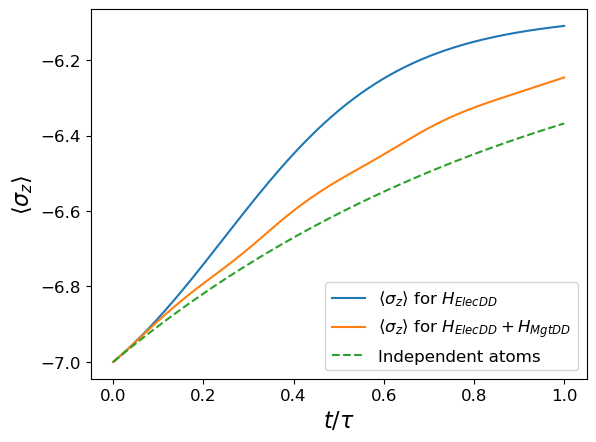

In [103]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz67_CS, label=L"$\langle\sigma_z\rangle$ for $H_{ElecDD}$")
plot(T, mean_σz67_QC, label=L"$\langle\sigma_z\rangle$ for $H_{ElecDD}+H_{MgtDD}$")
plot(T, mean_σz67_ind, label="Independent atoms", linestyle="--")

xlabel(L"t/\tau", fontsize=16)
ylabel(L"$\langle\sigma_z\rangle$", fontsize=16)

legend()
pygui(false); gcf()

In [104]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/SigmazComparisonElec_ElecMgt_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

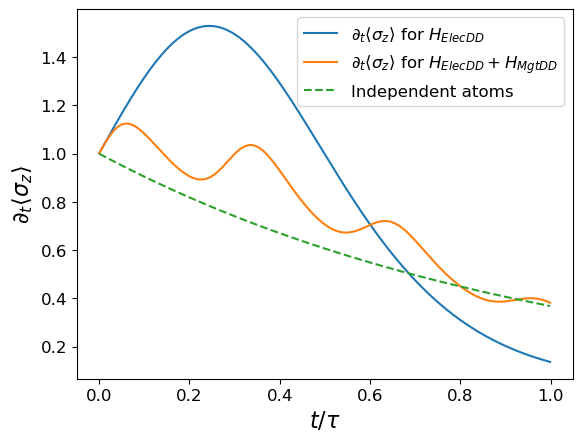

In [105]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T[1:end-1], diff(mean_σz67_CS)./Tstep, label=L"$\partial_t\langle\sigma_z\rangle$ for $H_{ElecDD}$")
plot(T[1:end-1], diff(mean_σz67_QC)./Tstep, label=L"$\partial_t\langle\sigma_z\rangle$ for $H_{ElecDD}+H_{MgtDD}$")
plot(T[1:end-1], diff(mean_σz67_ind)./Tstep, label="Independent atoms", linestyle="--")

xlabel(L"t/\tau", fontsize=16)
ylabel(L"$\partial_t\langle\sigma_z\rangle$", fontsize=16)

legend()
pygui(false); gcf()

In [106]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/DiffSigmazComparisonElec_ElecMgt_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

### Plot the expectation value of sigmax/y for the independent case: Don't look at these values! (cf theoretical description CollectiveSpins)

In [107]:
Sxt_ind = [CollectiveSpins.independent.sx(ρ) for ρ in ρt_ind]
Syt_ind = [CollectiveSpins.independent.sy(ρ) for ρ in ρt_ind]
Szt_ind = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
mean_σx_ind = [mean(subarray) for subarray in Sxt_ind]
mean_σy_ind = [mean(subarray) for subarray in Syt_ind]
mean_σz_ind = [mean(subarray) for subarray in Szt_ind];

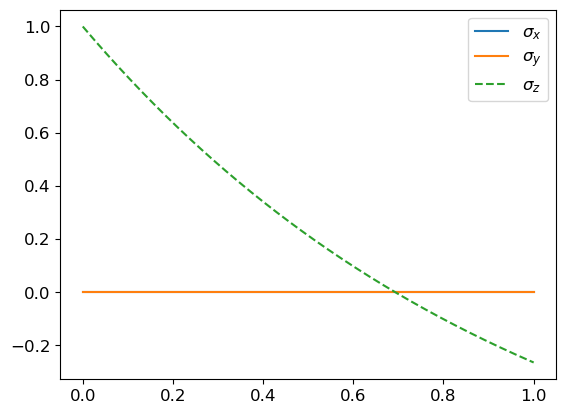

In [108]:
close("all")
figure()

plot(T, mean_σx_ind, label=L"\sigma_x")
plot(T, mean_σy_ind, label=L"\sigma_y", linestyle="-")
plot(T, mean_σz_ind, label=L"\sigma_z", linestyle="--")

legend()
gcf()